In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append('/solver/')
import solver

from solver.Mesh import *
from solver.SolverField import *
from solver.aux_solver import *
from solver.SbnSolver import *
from solver.DigitalTwin import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Simulation of 2 laser beams propagating inside an SBN crystal

In [4]:
### arrayfire configuration
print('Available Backends -> ', af.get_available_backends())

###set backend and device
af.set_backend('cuda')
af.set_device(0)

###print info
print(af.info_str())


Available Backends ->  ('cuda', 'opencl')
ArrayFire v3.6.1 (CUDA 64bit)
[0] : GeForce_GTX_1050 (Compute 6.1)



## 1.1. Some Auxiliary Functions

In [105]:
def phase_slip(x,y,A,w,x0,y0,vx,vy,width):
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**4) *np.exp((
                         ((x-x0)<0)*1j*np.pi))
    
    return new_field

def super_gauss(x,y,A,w,x0,y0,vx,vy,width,phase=0,x00=0,y00=0):
    aux = (((x - x0)*(x - x0)+ (y - y0)*(y - y0)) <= ( 0.8**2* (w*w)))
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**2)+1e-6
    new_field = new_field * (np.exp((1j*((vx*(x-x00))+(vy*(y-y00)))*aux)+1j*phase))
    return new_field

def whitenoise_2d_field_1(x,A):
    
    new_field = A*(0.5-np.random.rand(x.shape[0],x.shape[1]))*2         
    return new_field

def whitenoise_2d_field(x,A):
    np.random.seed()
    new_field = np.random.normal(0,scale=A, size=(x.shape[0],x.shape[1]))#
    return new_field

def whitenoise_1d_field(x,A):
    new_field = np.random.normal(0,scale=A, size=(x.shape[0]))#
    return new_field


def periodic_noise(y,A,k):
    new_field = A*np.sin(k*y)    
    return new_field

## 1.2. Configure Simulator and run

$$ i \partial_z E_{1} + \frac{1}{2} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_1+ \alpha E_1 = 0$$
$$ i \partial_z E_{2} + \frac{1}{2\gamma} \nabla ^{2}_{\perp} E_{2} + c_{2} \Delta n_{max} \gamma \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_2+ \alpha E_2 = 0$$

![image](image.png)

$\Delta n_{max} = \frac{1}{2}n_{e}^{3}V/d$ with $d=5mm$ being the crystal width. The typical crystal length is around 2cm.

## 2. Setting up a 2D simulation with a vortex state

In [133]:
for run_n in range(0,30):

    # Simulation Box to match experiment
    pixel_pitch = 1.25e-6
    magnification = 200/60
    x_camera = np.arange(0,4000)*pixel_pitch  #micrometers
    y_camera = np.arange(0,3000)*pixel_pitch



    ## Crystal
    lx=x_camera[-1]/ magnification
    ly=y_camera[-1]/ magnification
    lz=20e-3
    n_passages = 5 ###increase to see more dynamics, but in reality we have just 1

    ## start digital twin model
    c1 = 1 #rxx / r33
    c2 = 40/250 # rxx / r33
    V=400
    Isat = 200 #mW/cm2

    SBN_sim = DigitalTwin(lx=lx,ly=ly,lz=n_passages * lz,
                        V=V,c1=c1,c2=c2,Isat=Isat,
                        alpha=0)
    run_number=run_n
    saveDir = 'E:\\Quarmen2d_sim_new1\\'+str(run_number)+'\\'

    SBN_sim.start_simulation_config(Nx=256,Ny=256,dz=0.05,dims=2, save_dir=saveDir,stride=50)


    #######################################################################################
    #############State Initialization######################################################
    #######################################################################################

    If1=40

    factor_t = SBN_sim.factor_t

    SUPER_GAUSS_EXP = 2

    X, Y = SBN_sim.xx, SBN_sim.yy
    X -= X.max()/2
    Y -= Y.max()/2


    ########################################################
    #################   E1    ##############################
    ########################################################

    velocity = 0

    gaussian_beam = np.zeros(np.shape(X)) + 0j

    wx1 = 800e-6 * factor_t
    wy1 = 800e-6 * factor_t

    x_pos = -0* 200e-6 * factor_t
    y_pos = 0

    gaussian_beam += np.exp(-((2.0* (
                            (X - x_pos) ** 2.0 / (wx1**2.0)
                        +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                            ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

    gaussian_beam*=np.exp(1j*velocity*X)

    print("sound velocity ->", np.sqrt(If1/Isat), "fluid velocity ->", velocity)

    gaussian_beam*=np.sqrt(If1)

    A_noise=0.5
    gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))
    SBN_sim.field1.add_field_numpy(gaussian_beam)


    ########################################################
    #################   E2    ##############################
    ########################################################

    If2=10

    v2 = 0

    gaussian_beam = np.zeros(np.shape(X)) + 0j

    wx1 = 800e-6 * factor_t
    wy1 = 800e-6 * factor_t

    x_pos = -0* 200e-6 * factor_t
    y_pos = 0

    gaussian_beam += np.exp(-((2.0* (
                            (X - x_pos) ** 2.0 / (wx1**2.0)
                        +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                            ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

    x_pos_vortex = 0
    y_pos_vortex = 0
    theta = np.arctan2(Y-y_pos_vortex,X-x_pos_vortex) 
    l=1
    vortex_phase = np.exp(1j*l*theta)
    gaussian_beam*=vortex_phase

    print("sound velocity", np.sqrt(If1/Isat), velocity)

    gaussian_beam*=np.sqrt(If2)
    A_noise=0.0
    gaussian_beam = gaussian_beam*(1+A_noise*whitenoise_2d_field(X,A_noise))


    SBN_sim.field2.add_field_numpy(gaussian_beam)

    #SBN_sim.plot()

    simulate = True
    if simulate:
        SBN_sim.run()

delta_n -> 0.0001235560064
lx -> 302.4397292938621
ly -> 226.81088976051322
lz -> 29.185161053619055
healing length - > 7.012273216965854e-05
dx-> 1.1814051925541489 dy-> 0.8859800381270048
total steps to simulate -> 11
(256, 256)
(256, 256)
sound velocity -> 0.4472135954999579 fluid velocity -> 0
sound velocity 0.4472135954999579 0
Stride 0 of 11
Stride 1 of 11
Stride 2 of 11
Stride 3 of 11
Stride 4 of 11
Stride 5 of 11
Stride 6 of 11
Stride 7 of 11
Stride 8 of 11
Stride 9 of 11
Stride 10 of 11
delta_n -> 0.0001235560064
lx -> 302.4397292938621
ly -> 226.81088976051322
lz -> 29.185161053619055
healing length - > 7.012273216965854e-05
dx-> 1.1814051925541489 dy-> 0.8859800381270048
total steps to simulate -> 11
(256, 256)
(256, 256)
sound velocity -> 0.4472135954999579 fluid velocity -> 0
sound velocity 0.4472135954999579 0
Stride 0 of 11
Stride 1 of 11
Stride 2 of 11
Stride 3 of 11
Stride 4 of 11
Stride 5 of 11
Stride 6 of 11
Stride 7 of 11
Stride 8 of 11
Stride 9 of 11
Stride 10 of 1

## 2. Analysis

## 2.1 Load Data

In [43]:
from solver.af_loader import *


sim_state = []
sim_state2 = []

zz= []
n_state=50
for passage in range(0, n_state):
    saveDir = saveDir
    print(saveDir)
    my_mesh = mesh(saveDir+"\\")
    stride_read = 1

    ntotalfiles = len([f for f in os.listdir(saveDir+"\\gnlse_field\\") if f.endswith('.af')])
    index = int(ntotalfiles * passage/n_state)-1

    print(ntotalfiles,passage/n_passages, (index+1)/ntotalfiles)
    
    
    simulation_data,zs = load_data_folder(saveDir+"\\gnlse_field\\", my_mesh,index=1,stride_read=stride_read, index_to_read = index)
    simulation_data2,zs = load_data_folder(saveDir+"\\gnlse_field2\\",my_mesh, index=2, stride_read=stride_read, index_to_read = index)
    
    sim_state.append(np.transpose(simulation_data[0]))
    sim_state2.append(np.transpose(simulation_data2[0]))
    zz.append(zs[0])

    
sim_state=np.array(sim_state)
sim_state2=np.array(sim_state2)

E:\Quarmen2d_sim\1\
59 0.0 0.0
E:\Quarmen2d_sim\1\
59 0.2 0.01694915254237288
E:\Quarmen2d_sim\1\
59 0.4 0.03389830508474576
E:\Quarmen2d_sim\1\
59 0.6 0.05084745762711865
E:\Quarmen2d_sim\1\
59 0.8 0.06779661016949153
E:\Quarmen2d_sim\1\
59 1.0 0.0847457627118644
E:\Quarmen2d_sim\1\
59 1.2 0.11864406779661017
E:\Quarmen2d_sim\1\
59 1.4 0.13559322033898305
E:\Quarmen2d_sim\1\
59 1.6 0.15254237288135594
E:\Quarmen2d_sim\1\
59 1.8 0.1694915254237288
E:\Quarmen2d_sim\1\
59 2.0 0.1864406779661017
E:\Quarmen2d_sim\1\
59 2.2 0.2033898305084746
E:\Quarmen2d_sim\1\
59 2.4 0.23728813559322035
E:\Quarmen2d_sim\1\
59 2.6 0.2542372881355932
E:\Quarmen2d_sim\1\
59 2.8 0.2711864406779661
E:\Quarmen2d_sim\1\
59 3.0 0.288135593220339
E:\Quarmen2d_sim\1\
59 3.2 0.3050847457627119
E:\Quarmen2d_sim\1\
59 3.4 0.3389830508474576
E:\Quarmen2d_sim\1\
59 3.6 0.3559322033898305
E:\Quarmen2d_sim\1\
59 3.8 0.3728813559322034
E:\Quarmen2d_sim\1\
59 4.0 0.3898305084745763
E:\Quarmen2d_sim\1\
59 4.2 0.4067796610169

## 2.2 Plot States

Text(0, 0.5, '$y(mm)$')

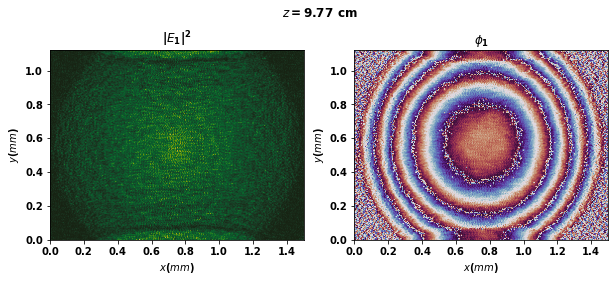

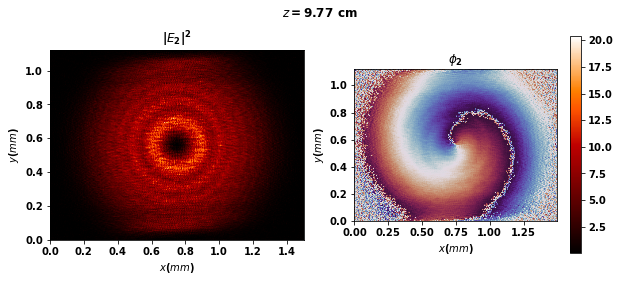

In [44]:
from solver.analysis_auxiliary_functions import *
import cmocean

index_plot = -1
z_value = zz[index_plot]/SBN_sim.factor_z*1e2
extent = [0,SBN_sim.lx*1e3,0,SBN_sim.ly*1e3]

fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_1|^2$')
ax[0].imshow(np.abs(sim_state[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')

ax[1].set_title(r'$\phi_1$')
ax[1].imshow(np.angle(sim_state[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_2|^2$')
im = ax[0].imshow(np.abs(sim_state2[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=plt.cm.gist_heat)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')
plt.colorbar(im)

ax[1].set_title(r'$\phi_2$')
ax[1].imshow(np.angle(sim_state2[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


## 3. Track the dynamics of the vortex center

1. Method to compute the center of the vortex
2. Compute the MSD 
3. Try to understand the Heat Bath

63 63


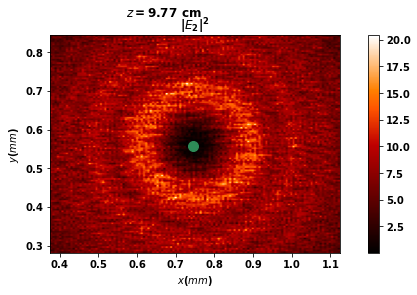

In [45]:
fig,ax = plt.subplots(1,1,figsize=[10,4])

extent = [SBN_sim.lx*1e3/4,3*SBN_sim.lx*1e3/4,SBN_sim.ly*1e3/4,3*SBN_sim.ly*1e3/4]

temp_state = np.abs(sim_state2[index_plot]**2)[int(SBN_sim.Ny/4):int(3*SBN_sim.Ny/4),int(SBN_sim.Nx/4):int(3*SBN_sim.Nx/4)]
fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax.set_title(r'$|E_2|^2$')
im = ax.imshow(temp_state, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=plt.cm.gist_heat)
ax.set_xlabel(r'$x(mm)$')
ax.set_ylabel(r'$y(mm)$')
plt.colorbar(im)
xp,yp = np.unravel_index(temp_state.argmin(), temp_state.shape)
print(yp,xp)
ax.plot(extent[0] + xp*SBN_sim.lx*1e3 / SBN_sim.Nx, extent[2] + yp*SBN_sim.ly*1e3 / SBN_sim.Ny ,'o',color='seagreen',ms=10)

In [60]:
from scipy.optimize import curve_fit

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))
    return g.ravel()



# create new data with these parameters
data_fitted = twoD_Gaussian((x, y), *popt)


In [79]:
xpos=[]
ypos=[]
for index_plot in range(5,n_state):
    temp_state = np.abs(sim_state2[index_plot]**2)[int(SBN_sim.Ny/4):int(3*SBN_sim.Ny/4),int(SBN_sim.Nx/4):int(3*SBN_sim.Nx/4)]
    

    data = -1*temp_state
    data -= np.min(data)

    h, w = data.shape
    data = data.ravel()


    x = np.linspace(0, w, w)
    y = np.linspace(0, h, h)
    x, y = np.meshgrid(x, y)

    # initial guess of parameters
    
    xp,yp = np.unravel_index(temp_state.argmin(), temp_state.shape)
    try:
        initial_guess = (np.max(data), xp,yp,10,10,0,0)

        # find the optimal Gaussian parameters
        popt, pcov = curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess) 
        new_xp, new_yp = popt[1],popt[2]
        xpos.append(new_xp)
        ypos.append(new_yp)
    except:
        print(index_plot)
        xpos.append(xp)
        ypos.append(yp)

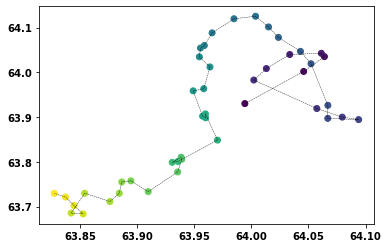

In [85]:
fig,ax = plt.subplots()
ax.scatter(xpos,ypos,marker = 'o',c=np.arange(0,len(xpos)))
ax.plot(xpos,ypos,ms=None,ls='--',lw=0.4,c='k')

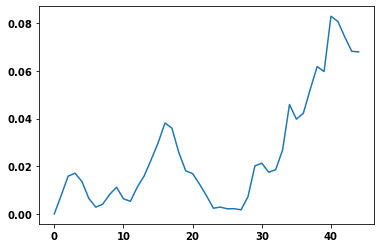

In [86]:
deltax = xpos - xpos[0]
deltay = ypos - ypos[0]
SD = deltax**2 + deltay**2
fig,ax = plt.subplots()
ax.plot(SD)

## 3.3 Load For every simulation and compute the vortex position

In [109]:
from solver.af_loader import *
all_x_pos = []
all_y_pos = []

for i in range(0,30):
    print(i,' of ', 30, end='\r')

    xpos=[]
    ypos=[]

    sim_state = []
    sim_state2 = []

    zz= []
    n_state=50
    for passage in range(0, n_state):
        saveDir = 'E:\\Quarmen2d_sim\\'+str(i)+"\\"
        my_mesh = mesh(saveDir)
        stride_read = 1

        ntotalfiles = len([f for f in os.listdir(saveDir+"\\gnlse_field\\") if f.endswith('.af')])
        index = int(ntotalfiles * passage/n_state)-1


        
        
        simulation_data,zs = load_data_folder(saveDir+"\\gnlse_field\\", my_mesh,index=1,stride_read=stride_read, index_to_read = index)
        simulation_data2,zs = load_data_folder(saveDir+"\\gnlse_field2\\",my_mesh, index=2, stride_read=stride_read, index_to_read = index)
        
        sim_state.append(np.transpose(simulation_data[0]))
        sim_state2.append(np.transpose(simulation_data2[0]))
        zz.append(zs[0])

        
    sim_state=np.array(sim_state)
    sim_state2=np.array(sim_state2)



    for index_plot in range(5,n_state):
        temp_state = np.abs(sim_state2[index_plot]**2)[int(SBN_sim.Ny/4):int(3*SBN_sim.Ny/4),int(SBN_sim.Nx/4):int(3*SBN_sim.Nx/4)]
        

        data = -1*temp_state
        data -= np.min(data)

        h, w = data.shape
        data = data.ravel()


        x = np.linspace(0, w, w)
        y = np.linspace(0, h, h)
        x, y = np.meshgrid(x, y)

        # initial guess of parameters
        
        xp,yp = np.unravel_index(temp_state.argmin(), temp_state.shape)
        try:
            initial_guess = (np.max(data), xp,yp,10,10,0,0)

            # find the optimal Gaussian parameters
            popt, pcov = curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess) 
            new_xp, new_yp = popt[1],popt[2]
            xpos.append(new_xp)
            ypos.append(new_yp)
        except:
            print(index_plot)
            xpos.append(xp)
            ypos.append(yp)
    
    all_x_pos.append(np.array(xpos))
    all_y_pos.append(np.array(ypos))

all_x_pos = np.array(all_x_pos)
all_y_pos = np.array(all_y_pos)

Text(0, 0.5, 'MSD')

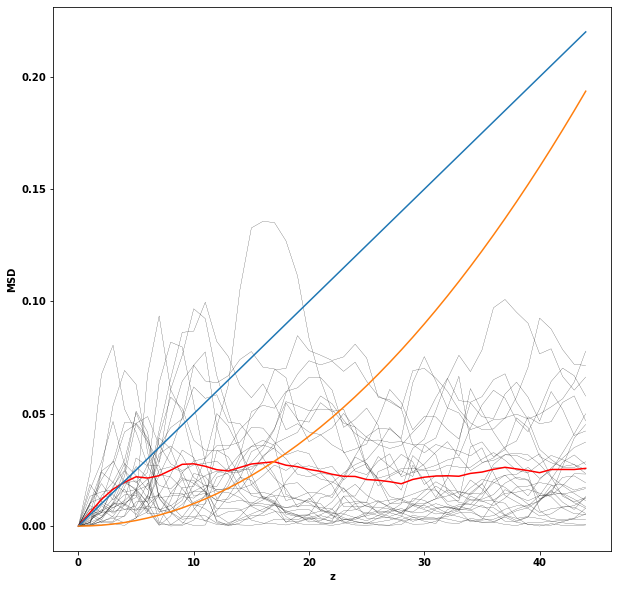

In [136]:
fig,ax = plt.subplots(figsize=[10,10])

SD_all = []
for ind in range(0,len(all_x_pos)):
    deltax = all_x_pos[ind] - all_x_pos[ind][0]
    deltay = all_y_pos[ind] - all_y_pos[ind][0]
    SD = deltax**2 + deltay**2
    SD_all.append(np.array(SD))
    
    ax.plot(SD,ls='-',lw=0.2,color='k')
SD_all = np.array(SD_all)

ax.plot(np.mean(SD_all,axis=0),color='red')
ax.plot(np.arange(0,len(SD)),0.005*np.arange(0,len(SD)),label='Brownian Motion Limit')
ax.plot(np.arange(0,len(SD)),0.0001*np.arange(0,len(SD))**2,label='Superdiffusive Motion')
ax.set_xlabel('z')
ax.set_ylabel('MSD')

c:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


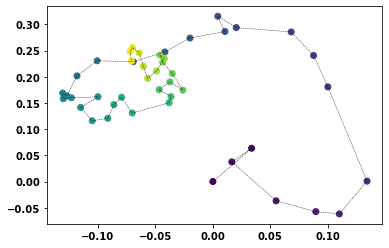

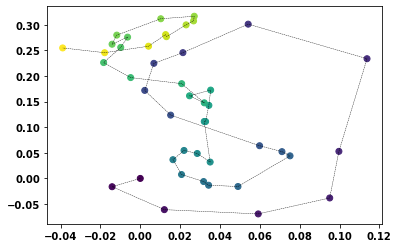

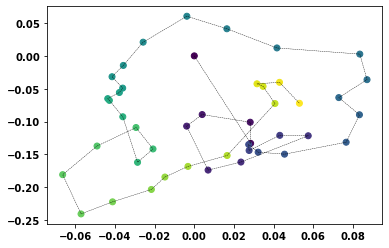

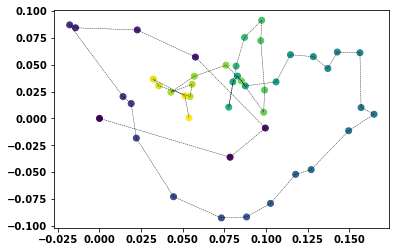

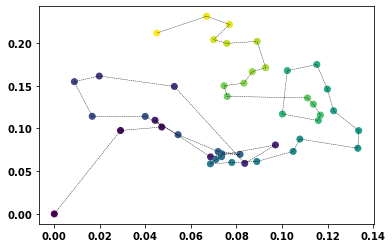

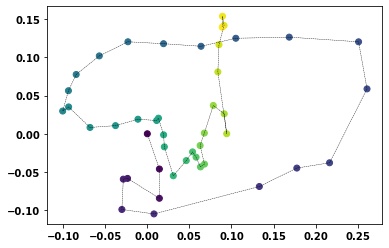

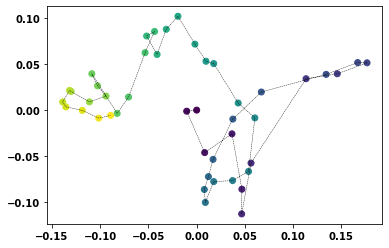

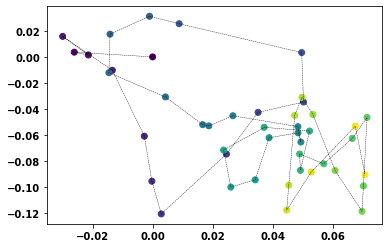

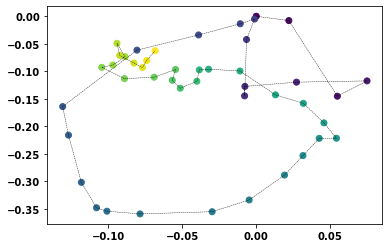

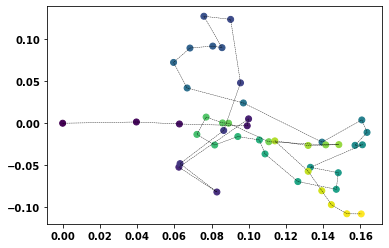

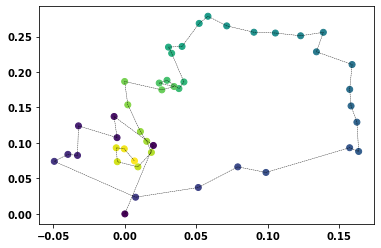

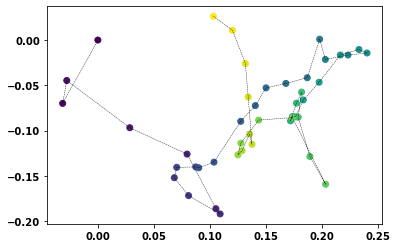

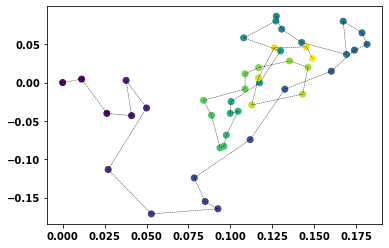

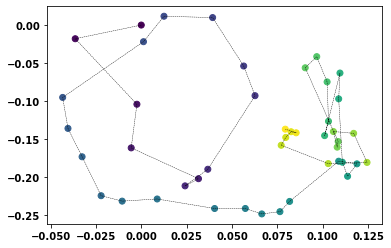

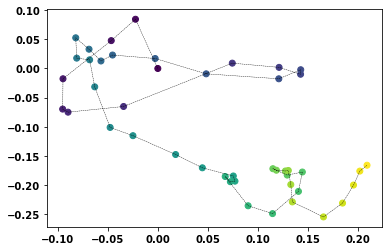

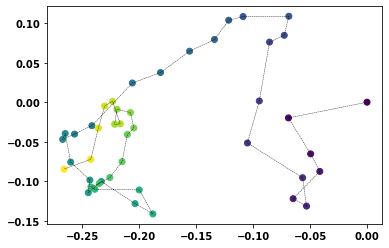

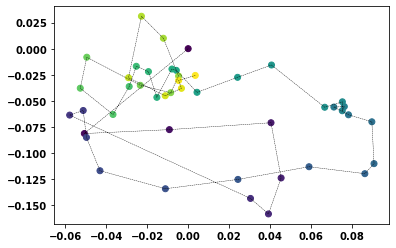

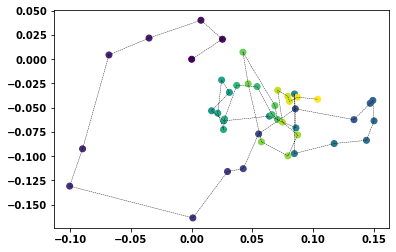

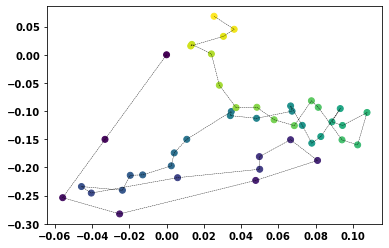

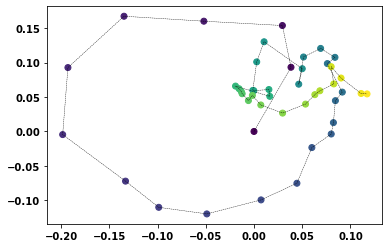

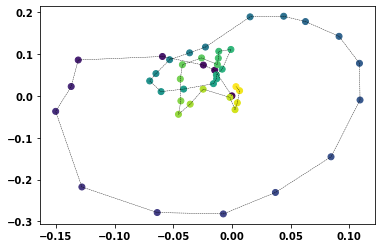

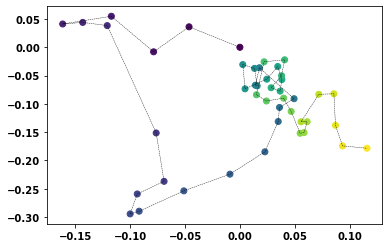

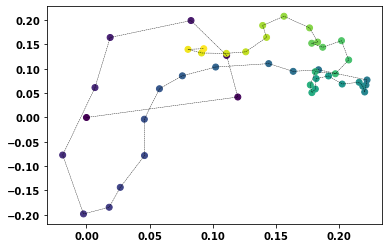

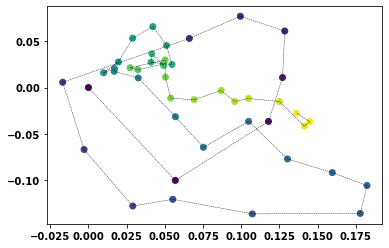

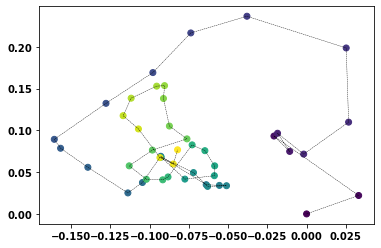

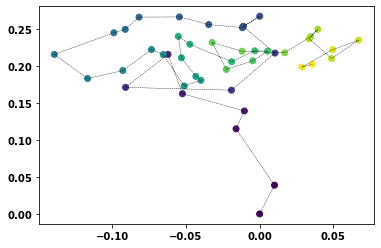

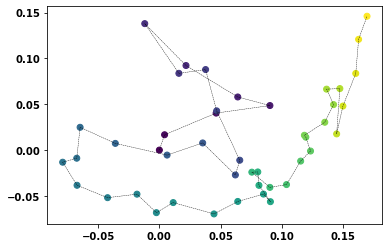

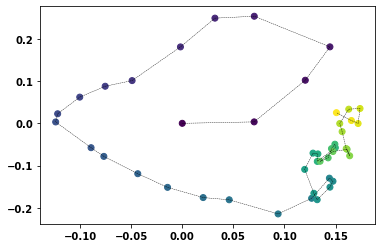

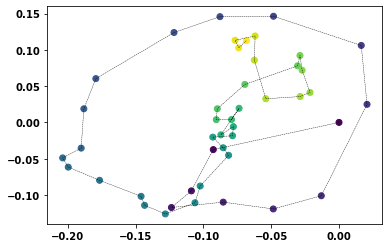

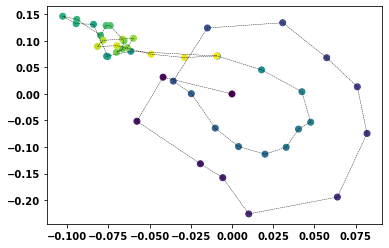

In [131]:

for ind in range(0,len(all_x_pos)):
    fig,ax = plt.subplots()
    deltax = all_x_pos[ind] - all_x_pos[ind][0]
    deltay = all_y_pos[ind] - all_y_pos[ind][0]
    ax.scatter(deltax,deltay,marker = 'o',c=np.arange(0,len(xpos)))
    ax.plot(deltax,deltay,ms=None,ls='--',lw=0.4,c='k')

In [115]:
SD_all

array([0.        , 0.002744  , 0.00596342, 0.01764803, 0.0249039 ,
       0.05114302, 0.04178279, 0.01223854, 0.00596106, 0.00794678,
       0.01892831, 0.01566662, 0.00185564, 0.0006085 , 0.00423995,
       0.00983901, 0.01326353, 0.01116791, 0.00600432, 0.00511029,
       0.00181775, 0.00237767, 0.00517709, 0.01022135, 0.01082894,
       0.01065922, 0.02424962, 0.02645128, 0.03195526, 0.02858025,
       0.01850604, 0.02239517, 0.02205259, 0.01431077, 0.01160255,
       0.01106969, 0.0116466 , 0.0145667 , 0.01510887, 0.01629188,
       0.01466369, 0.0130891 , 0.00800396, 0.00551175, 0.00522556])

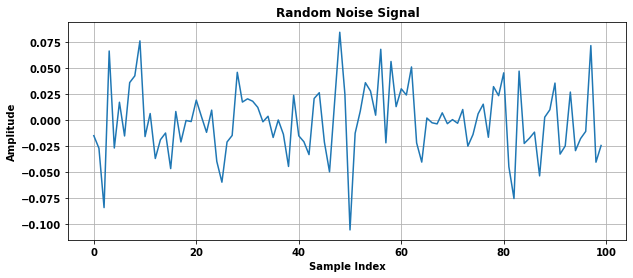

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency
N = 1024   # Number of points

# Frequency array
f = np.linspace(0, fs/2, N//2)

# Define the spectral density function, S(f)
def spectral_density(f):
    return 1/np.sqrt(1 + f**2)*(np.sqrt(1 + f**2))  # Example: 1/(1+f^2)

# Generate random phases
phi = np.random.uniform(0, 2*np.pi, N//2)

# Create the spectrum from the square root of the spectral density
amplitude = np.sqrt(spectral_density(f))
real_part = amplitude * np.cos(phi)
imag_part = amplitude * np.sin(phi)
spectrum = np.concatenate((real_part + 1j*imag_part, real_part[-2:0:-1] - 1j*imag_part[-2:0:-1]))

# Inverse Fourier Transform to get the time domain signal
noise_signal = np.fft.ifft(spectrum).real

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(noise_signal[:100])  # Plot the first 100 points to see the waveform
plt.title('Random Noise Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
